# Safe Keras Notebook 
### First set some path variables: this notebook expects to find the repository root in your home directory. You can change this by editing the last sys.path.append line to reflect with the repository root is found on your system

In [1]:
import sys
import os

from os.path import expanduser

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)
home = expanduser("~")
sys.path.append(os.path.abspath(home+'/AI-SDC'))


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Safe Keras
from safemodel.classifiers import SafeKerasModel

2022-09-01 15:25:10.423384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 15:25:10.423426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## A Quick Start Guide to implementing Safer Keras Models
### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***we make datasets with few samples but with many features to force the target model to overfit.***


**NOTE**: batch_size 25 so DP optimizer would run with same hyperparams

**NOTE**: Next cell detemrienswhich dataset is used

In [3]:
simple_data_for_pytests = False

In [4]:
if not simple_data_for_pytests:
    n_classes = 2

    # (X,y): Original distribution
    X, y = make_classification(
        n_samples=1000,
        n_classes=n_classes,
        n_features=300,
        n_informative=300,
        n_redundant=0,
        n_repeated=0,
        random_state=15,
    )
    # One-hot encoding of the label
    y = np.eye(n_classes)[y]

    # (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
    # (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
    Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

    # (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
    Xd, yd = make_classification(
        n_samples=1000,
        n_classes=n_classes,
        n_features=300,
        n_informative=300,
        n_redundant=0,
        n_repeated=0,
        random_state=42,
    )
    yd = np.eye(n_classes)[yd]

    # Split into train (member) and test (non-member) datasets
    # Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
    # we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
    Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(
        Xt, yt, test_size=0.5, shuffle=False
    )

    # Set membership status for future tests
    Xt_membership = np.vstack(
        (
            np.ones((Xt_member.shape[0], 1), np.uint8),
            np.zeros((Xt_nonmember.shape[0], 1), np.uint8),
        )
    ).flatten()

    X = Xt_member
    y = yt_member
    Xval = Xt_nonmember
    yval = yt_nonmember

In [5]:
if simple_data_for_pytests:
    from sklearn import datasets

    def get_data():
        iris = datasets.load_iris()
        x = np.asarray(iris.data, dtype=np.float64)
        y = np.asarray(iris.target, dtype=np.float64)
        x = np.vstack([x, (7, 2.0, 4.5, 1)])
        y = np.append(y, 4)
        return x, y

    xall, yall = get_data()
    n_classes = 4
    X, Xval, y, yval = train_test_split(
        xall, yall, test_size=0.2, shuffle=True, random_state=12345
    )

    y = tf.one_hot(y, n_classes)
    yval = tf.one_hot(yval, n_classes)
# yval

## Define the target model architecture

*Again, we use a rather big model (for the classification task) to favour overfitting.*

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

# amke results repeatable
tf.random.set_seed(12345)
initializer = tf.keras.initializers.Zeros()

input_data = Input(shape=X[0].shape)
x = Dense(128, activation="relu", kernel_initializer=initializer)(input_data)
x = Dense(128, activation="relu", kernel_initializer=initializer)(x)
x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
output = Dense(n_classes, activation="softmax", kernel_initializer=initializer)(x)

2022-09-01 15:25:13.895455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 15:25:13.895520: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 15:25:13.895552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-09-01 15:25:13.895937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define the SafeModel

In [7]:
safeModel = SafeKerasModel(
    inputs=input_data,
    outputs=output,
    name="safekeras-test",
    num_samples=X.shape[0],
    epochs=10,
)

- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.



### Set loss and compile

In [8]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE
)


safeModel.compile(loss=loss, optimizer=None)

### Fit the model

DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
The requirements for DP are met, current epsilon is: 4.382426906944152.Calculated from the parameters:  Num Samples = 250, batch_size = 1, epochs = 20.

Epoch 1/20
250/250 [==============================] - 5s 12ms/step - loss: 12149.9199 - accuracy: 0.4840 - val_loss: 34215.3672 - val_accuracy: 0.4680
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 62432.8516 - accuracy: 0.5000 - val_loss: 124610.4844 - val_accuracy: 0.5280
Epoch 3/20
250/250 [==============================] - 3s 11ms/step - loss: 133553.0312 - accuracy: 0.5560 - val_loss: 207521.9844 - val_accuracy: 0.5480
Epoch 4/20
250/250 [==============================] - 2s 10ms/step - loss: 253178.8594 - accuracy: 0.5720 - val_loss: 281794.9375 - val_accuracy: 0.5480
Epoch 5/20
250/250 [==============================] - 3s 

2022-09-01 15:26:11.342047: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tfsaves/fit_model.tf/assets


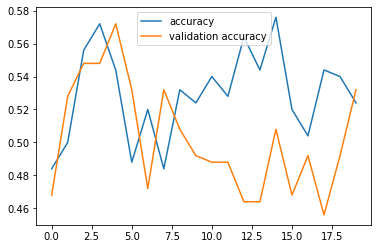

8/8 [==============================] - 0s 5ms/step - loss: 7443336.0000 - accuracy: 0.5640
training loss 7443336.0 accuracy 0.5640000104904175


In [9]:
epochs = 20
batch_size = 1

r_DP = safeModel.fit(
    X,
    y,
    validation_data=(Xval, yval),
    epochs=epochs,
    batch_size=batch_size,
)
if r_DP == None:
    print("You have chosen to exit. Reset relevant parameter values then re-run fit().")
else:
    plt.plot(r_DP.history["accuracy"], label="accuracy")
    plt.plot(r_DP.history["val_accuracy"], label="validation accuracy")
    plt.legend()
    plt.show()
    loss, acc = safeModel.evaluate(X, y)
    print(f"training loss {loss} accuracy {acc}")

### Compute privacy and check if requirements for Differential Privacy are met

In [10]:
num_samples = X.shape[0]
batch_size = safeModel.batch_size
epochs = 20

dp_met, privacy = safeModel.dp_epsilon_met(num_examples=num_samples, batch_size=batch_size, epochs=epochs)

print(f"with these settings privacy = {privacy}")

DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
with these settings privacy = 4.382426906944152


In [11]:
dp_met, msg = safeModel.check_epsilon(X.shape[0], safeModel.batch_size, safeModel.epochs)
print(f'Satisfies DP: {dp_met}')
print(f'{msg}')

DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
The requirements for DP are met, current epsilon is: 4.382426906944152.Calculated from the parameters:  Num Samples = 250, batch_size = 1, epochs = 20.

Satisfies DP: True
The requirements for DP are met, current epsilon is: 4.382426906944152.Calculated from the parameters:  Num Samples = 250, batch_size = 1, epochs = 20.



### Check model and request release

In [12]:
safeModel.save("safe1.h5")
safeModel.preliminary_check()
safeModel.request_release(filename="safe1.h5")

Model parameters are within recommended ranges.

INFO:tensorflow:Assets written to: tfsaves/requested_model.tf/assets
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f05d86b97c0>
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Recommendation is to allow release.



### Examine Checkfile


In [13]:
!echo "contents of checkfile are"; cat *_check*ile.json

contents of checkfile are
{
    "researcher": "andy",
    "model_type": "KerasModel",
    "model_save_file": "tfsaves/requested_model.tf",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file safe1.h5 through next step of checking procedure",
    "timestamp": "2022-09-01 15:26:14"
}